In [1]:
# import dependencies
from google.colab import auth
auth.authenticate_user()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
try:
  import pandasql as ps
except:
  !pip -q install pandasql
  import pandasql as ps
import datetime
import calendar

In [2]:
  %%bigquery --project double-catfish-305605 total_rows
SELECT COUNT(*) AS total_rows FROM `bigquery-public-data.iowa_liquor_sales.sales`

In [3]:
%%bigquery --project double-catfish-305605 total_cols 
SELECT COUNT(DISTINCT column_name) AS total_cols FROM  `bigquery-public-data.iowa_liquor_sales.INFORMATION_SCHEMA.COLUMNS` WHERE table_name = "sales"

In [4]:
print('This is a big dataset, with a total number of {} records and {} variables'.format(f"{total_rows['total_rows'].item():,}", total_cols['total_cols'].item()))

This is a big dataset, with a total number of 20,546,005 records and 24 variables


In [5]:
# filter dataset only from the last six months of 2020
%%bigquery --project double-catfish-305605 y2020
SELECT * FROM `bigquery-public-data.iowa_liquor_sales.sales` WHERE date BETWEEN '2020-7-01' AND '2020-12-31' ORDER BY date DESC

In [6]:
# add day_of_week, day, month, year, and holiday column
y2020['date'] = pd.to_datetime(y2020['date'])
y2020[['year','month','day']] = y2020.date.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
y2020['month'] = y2020['month'].map({'07':'July', '08':'August', '09':'September', '10':'October', '11':'November', '12':'December'})
y2020['day_of_week'] = y2020['date'].dt.day_name()
holiday = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/test/2010-2020 Holiday Dates.xlsx', sheet_name='HolidayDateList')
holiday['DAY_DATE'] = pd.to_datetime(holiday['DAY_DATE'])
y2020 = ps.sqldf("SELECT * FROM y2020 AS y LEFT JOIN holiday AS h ON y.date=h.DAY_DATE")

In [7]:
y2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341202 entries, 0 to 1341201
Data columns (total 37 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   invoice_and_item_number  1341202 non-null  object 
 1   date                     1341202 non-null  object 
 2   store_number             1341202 non-null  object 
 3   store_name               1341202 non-null  object 
 4   address                  1341202 non-null  object 
 5   city                     1341202 non-null  object 
 6   zip_code                 1341202 non-null  object 
 7   store_location           1215567 non-null  object 
 8   county_number            1341202 non-null  object 
 9   county                   1341202 non-null  object 
 10  category                 1341202 non-null  object 
 11  category_name            1341202 non-null  object 
 12  vendor_number            1341202 non-null  object 
 13  vendor_name              1341202 non-null 

In [8]:
# drop unnecessary columns
y2020 = y2020.drop(
    ['invoice_and_item_number',
     'store_number', 'address',
     'zip_code',
     'store_location',
     'county_number',
     'category',
     'vendor_number',
     'item_number',
     'DAY_DATE',
     'DAY_INT',
     'WEEKDAY',
     'HOLIDAY_DATE_SRC',
     'IS_HOL',
     'IS_FRB_BANK_OBS_HOL',
     'IS_NYSE_OBS_HOL',
     'IS_US_FEDERAL_OBS_HOL'], axis=1
     )

In [9]:
y2020.head()

,date,store_name,city,county,category_name,vendor_name,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day,day_of_week,HOLIDAY_NAME
0,2020-12-31 00:00:00.000000,Casey's General Store #2835 / Avoca,Avoca,POTTAWATTA,Spiced Rum,Heaven Hill Brands,Admiral Nelson Spiced Rum,24,375,2.99,4.49,6,26.94,2.25,0.59,2020,December,31,Thursday,None
1,2020-12-31 00:00:00.000000,Casey's General Store #2521 / Adair,Adair,ADAIR,Spiced Rum,DIAGEO AMERICAS,Captain Morgan Original Spiced,24,375,5.00,7.50,6,45.00,2.25,0.59,2020,December,31,Thursday,None
2,2020-12-31 00:00:00.000000,Quik Trip #544 / SE 14th DM,Des Moines,POLK,Spiced Rum,DIAGEO AMERICAS,Captain Morgan Original Spiced,24,375,5.00,7.50,24,180.00,9.00,2.37,2020,December,31,Thursday,None
3,2020-12-31 00:00:00.000000,Hy-Vee Food Store / Mount Pleasant,Mount Pleasant,HENRY,Cream Liqueurs,Gemini Spirits,Ryans Cream Liqueur,12,750,6.70,10.05,12,120.60,9.00,2.37,2020,December,31,Thursday,None
4,2020-12-31 00:00:00.000000,C Fresh Market,Des Moines,POLK,American Vodkas,LUXCO INC,Hawkeye Vodka Mini,12,50,4.13,6.20,12,74.40,0.60,0.15,2020,December,31,Thursday,None


In [10]:
y2020.tail()

,date,store_name,city,county,category_name,vendor_name,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day,day_of_week,HOLIDAY_NAME
1341197,2020-07-01 00:00:00.000000,I-80 Liquor / Council Bluffs,Council Bluffs,POTTAWATTA,Irish Whiskies,PROXIMO,Bushmills Irish Whiskey,12,1000,17.25,25.88,12,310.56,12.0,3.17,2020,July,01,Wednesday,None
1341198,2020-07-01 00:00:00.000000,Hy-Vee Food Store #1636 / Spencer,Spencer,CLAY,American Vodkas,Laird & Company,Five O'Clock Vodka,48,200,1.13,1.70,3,5.10,0.6,0.15,2020,July,01,Wednesday,None
1341199,2020-07-01 00:00:00.000000,Casey's General Store #2592 / Farmington,Farmington,VAN BUREN,Whiskey Liqueur,SAZERAC COMPANY INC,Southern Comfort PET,6,1750,20.26,30.39,6,182.34,10.5,2.77,2020,July,01,Wednesday,None
1341200,2020-07-01 00:00:00.000000,Hy-Vee Food Store #1 / Ames,Ames,STORY,Blended Whiskies,DIAGEO AMERICAS,Seagrams 7 Crown,12,1000,8.00,12.00,12,144.00,12.0,3.17,2020,July,01,Wednesday,None
1341201,2020-07-01 00:00:00.000000,John's Grocery,Iowa City,JOHNSON,Blended Whiskies,Jacob Rieger & Company LLC,Riegers Kansas City Whiskey,6,750,19.27,28.91,6,173.46,4.5,1.18,2020,July,01,Wednesday,None


In [11]:
print(f'Null Data: \n{y2020.isnull().sum()}\n')

Null Data: 
date                         0
store_name                   0
city                         0
county                       0
category_name                0
vendor_name                  0
item_description             0
pack                         0
bottle_volume_ml             0
state_bottle_cost            0
state_bottle_retail          0
bottles_sold                 0
sale_dollars                 0
volume_sold_liters           0
volume_sold_gallons          0
year                         0
month                        0
day                          0
day_of_week                  0
HOLIDAY_NAME           1310313
dtype: int64



In [12]:
sns.set_style("darkgrid")
sns.set(font_scale=1.0)
month = ['July','August','September','October','November','December']
day_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']

In [13]:
print('There are a total of {} transactions that happened in the last six months of 2020'.format(f"{len(y2020):,}"))

There are a total of 1,341,202 transactions that happened in the last six months of 2020


In [14]:
# bottles sold by the liquor category
bottles_sold_cat = ps.sqldf("SELECT SUM(bottles_sold) AS sales, category_name FROM y2020 GROUP BY category_name ORDER BY sales DESC")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


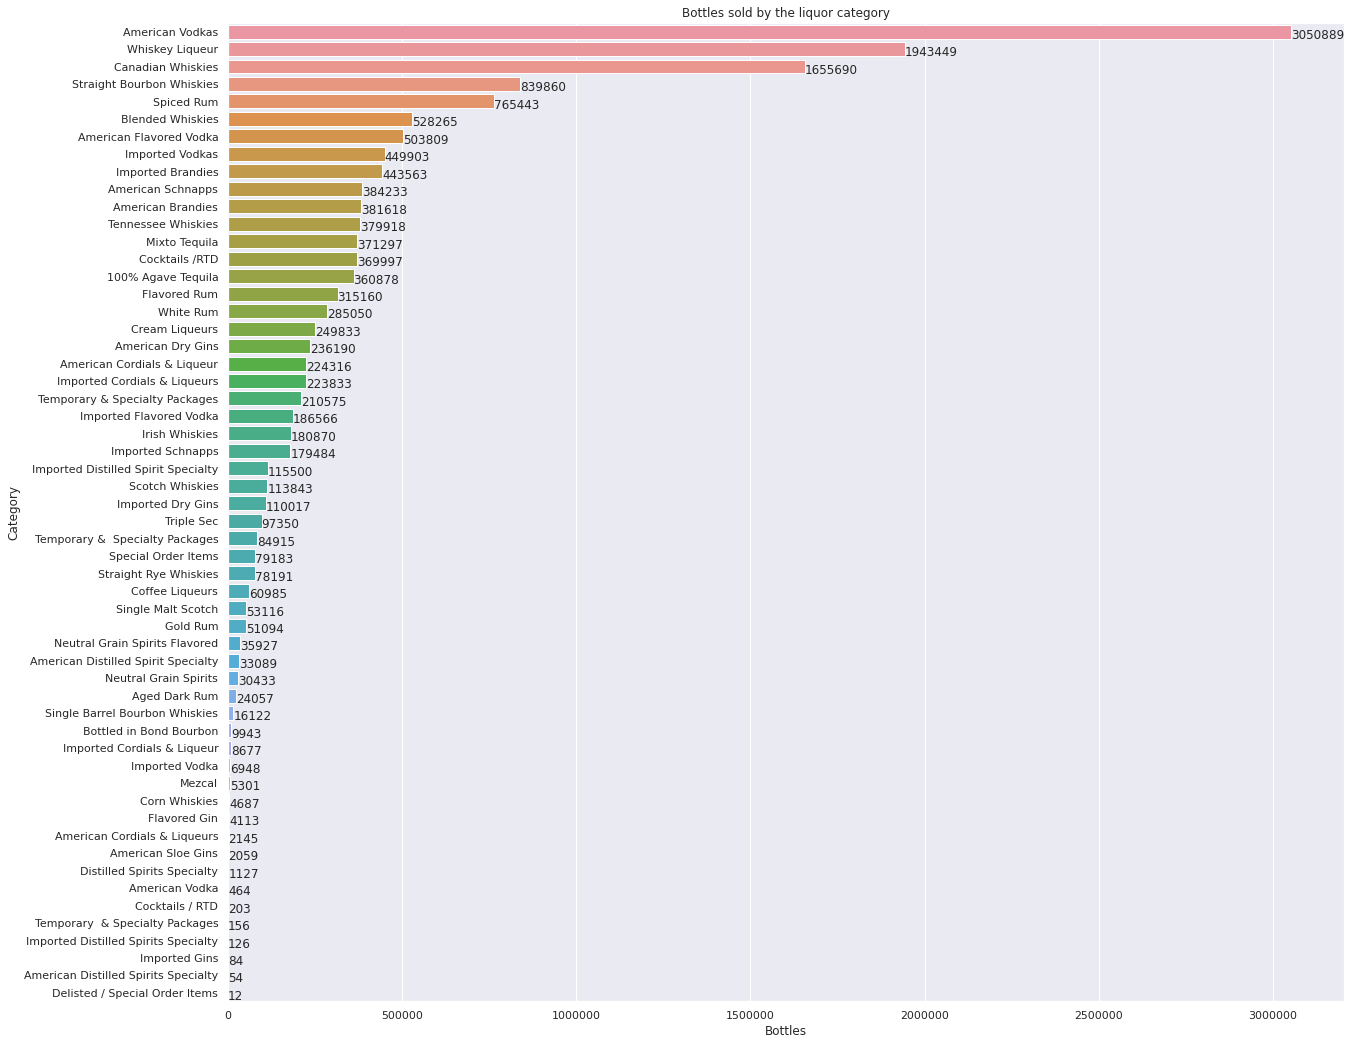

In [15]:
plt.figure(figsize=(20,18))
bottl_cat = sns.barplot(bottles_sold_cat.sales, bottles_sold_cat.category_name)
for i in bottl_cat.patches:
  x = i.get_x() + i.get_width() + float(0.4)
  y = i.get_y() + i.get_height()
  value = int(i.get_width())
  bottl_cat.text(x, y, value, ha="left")
plt.title("Bottles sold by the liquor category")
plt.xlabel("Bottles")
plt.ylabel("Category")
bottl_cat.ticklabel_format(useOffset=False, style='plain', axis='x')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

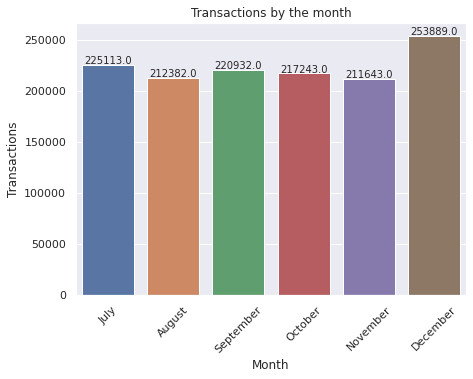

In [16]:
# transactions by the month
plt.figure(figsize=(7,5))
trans_m = sns.countplot(y2020['month'], order=month)
plt.title("Transactions by the month")
for i in trans_m.patches:
  trans_m.annotate(format(i.get_height(), '.1f'), 
  (i.get_x() + i.get_width() / 2., i.get_height()), 
  ha = 'center', va = 'center', 
  xytext = (0, 4), 
  textcoords = 'offset points',
  fontsize=10, rotation=0) 
plt.xlabel("Month")
plt.ylabel("Transactions")
plt.xticks(rotation=45)

In [17]:
# bottles sold by the month
bottles_sold_m = ps.sqldf("SELECT SUM(bottles_sold) AS bottles, month FROM y2020 GROUP BY month ORDER BY bottles DESC")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

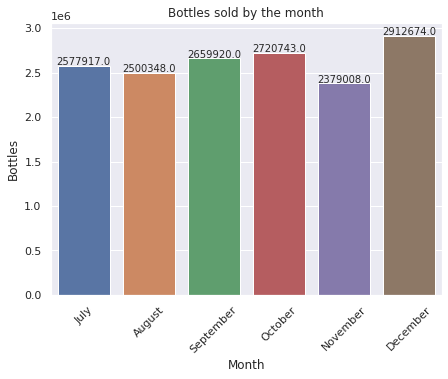

In [18]:
plt.figure(figsize=(7,5))
bottl_m = sns.barplot(bottles_sold_m.month, bottles_sold_m.bottles, order=month)
plt.title("Bottles sold by the month")
for i in bottl_m.patches:
  bottl_m.annotate(format(i.get_height(), '.1f'), 
  (i.get_x() + i.get_width() / 2., i.get_height()), 
  ha = 'center', va = 'center', 
  xytext = (0, 4), 
  textcoords = 'offset points',
  fontsize=10, rotation=0) 
plt.xlabel("Month")
plt.ylabel("Bottles")
plt.xticks(rotation=45)

In [19]:
# bottles sold by the liquor category every month
bottles_sold_cat_m = ps.sqldf("SELECT month, category_name, SUM(bottles_sold) AS sales FROM y2020 GROUP BY month, category_name ORDER BY month DESC")

Text(0.5, 138.5, 'Month')

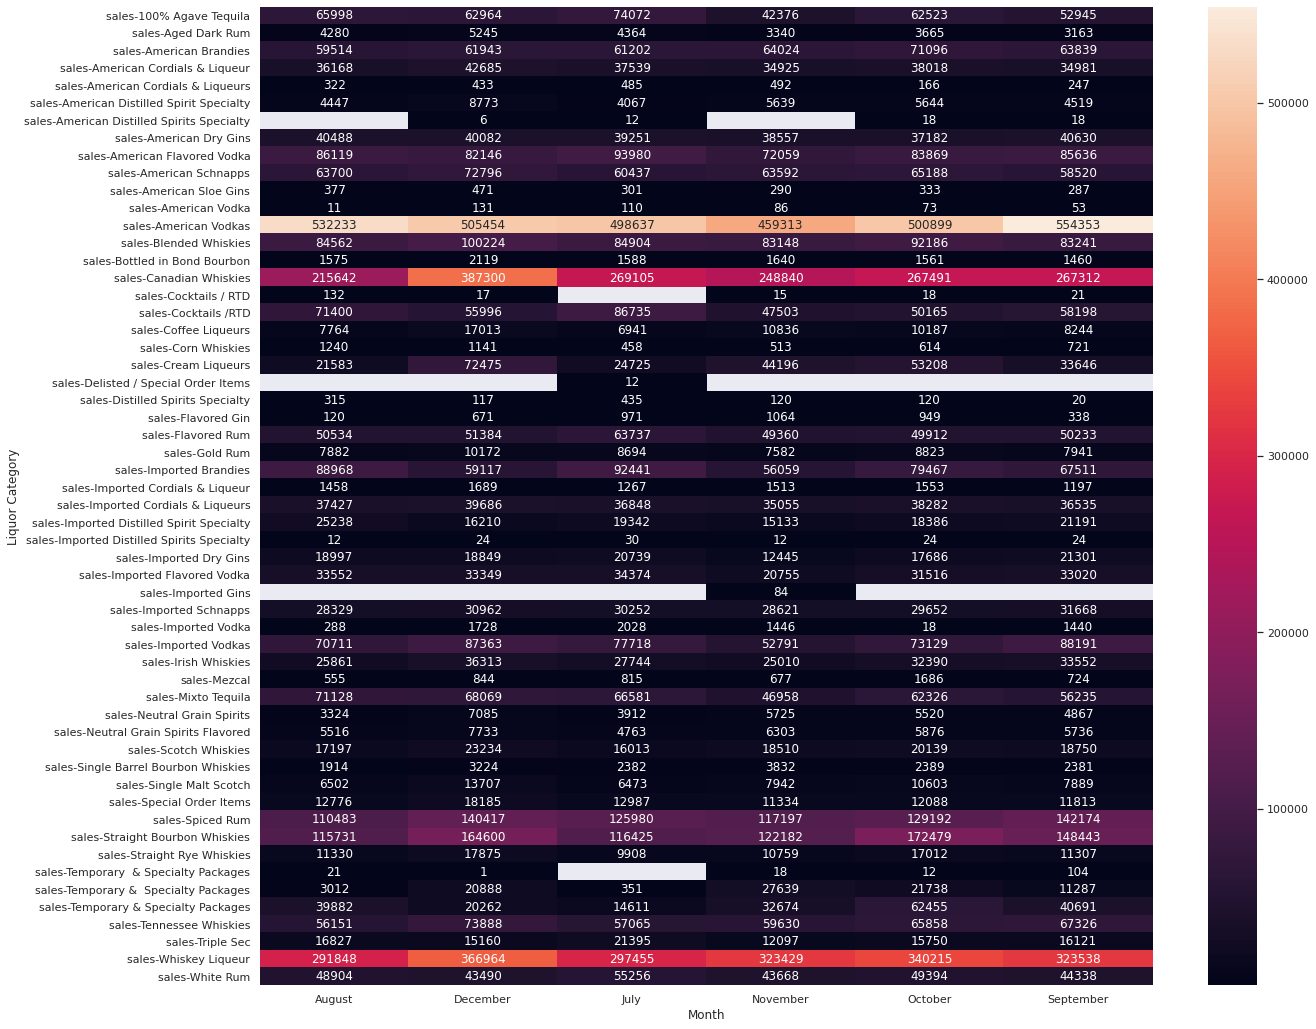

In [20]:
plt.figure(figsize=(20,18))
bottles_sold_cat_m_cf = bottles_sold_cat_m.pivot(index ='month', columns ='category_name', values =['sales']).T
sns.heatmap(bottles_sold_cat_m_cf, annot=True, fmt='g')
plt.ylabel('Liquor Category')
plt.xlabel('Month')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

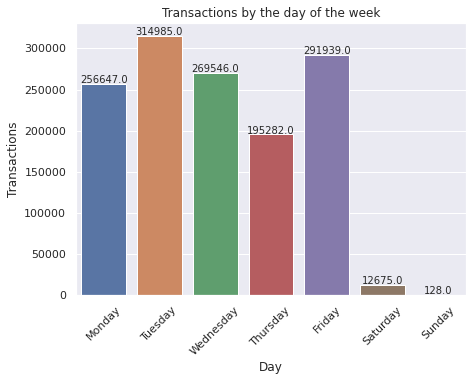

In [21]:
# transactions by the day of the week
plt.figure(figsize=(7,5))
trans_d = sns.countplot(y2020['day_of_week'], order=day_of_week)
plt.title("Transactions by the day of the week")
for i in trans_d.patches:
  trans_d.annotate(format(i.get_height(), '.1f'), 
  (i.get_x() + i.get_width() / 2., i.get_height()), 
  ha = 'center', va = 'center', 
  xytext = (0, 4), 
  textcoords = 'offset points',
  fontsize=10, rotation=0) 
plt.xlabel("Day")
plt.ylabel("Transactions")
plt.xticks(rotation=45)

In [22]:
# bottles sold by the day of the week
bottles_sold_d_w = ps.sqldf("SELECT SUM(bottles_sold) AS bottles, day_of_week FROM y2020 GROUP BY day_of_week ORDER BY bottles DESC")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

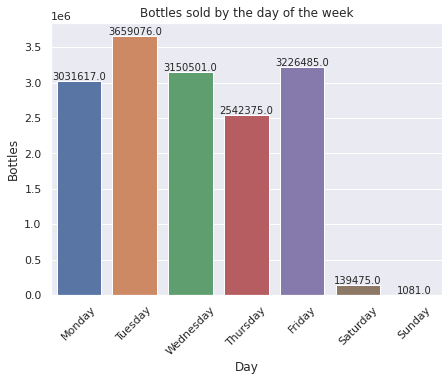

In [23]:
plt.figure(figsize=(7,5))
bottl_d = sns.barplot(bottles_sold_d_w.day_of_week, bottles_sold_d_w.bottles, order=day_of_week)
plt.title("Bottles sold by the day of the week")
for i in bottl_d.patches:
  bottl_d.annotate(format(i.get_height(), '.1f'), 
  (i.get_x() + i.get_width() / 2., i.get_height()), 
  ha = 'center', va = 'center', 
  xytext = (0, 4), 
  textcoords = 'offset points',
  fontsize=10, rotation=0) 
plt.xlabel("Day")
plt.ylabel("Bottles")
plt.xticks(rotation=45)

In [24]:
def weekday_count(start, end):
  start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
  end_date = datetime.datetime.strptime(end, '%d/%m/%Y')
  week = {}
  for i in range((end_date - start_date).days):
    day = calendar.day_name[(start_date + datetime.timedelta(days=i+1)).weekday()]
    week[day] = week[day] + 1 if day in week else 1
  return week

start = "01/07/2020"
end = "31/12/2020"
mon = weekday_count(start, end)['Monday']
tue = weekday_count(start, end)['Tuesday']
wed = weekday_count(start, end)['Wednesday']+1
thu = weekday_count(start, end)['Thursday']
fri = weekday_count(start, end)['Friday']
sat = weekday_count(start, end)['Saturday']
sun = weekday_count(start, end)['Sunday']

In [25]:
# average bottles sold by the day of the week
days = [tue, fri, wed, mon, thu, sat, sun]
ave = [bottles_sold_d_w['bottles'][i] / days[i] for i, x in enumerate(days)]
bottles_sold_d_w.insert(2, "Average", ave, True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

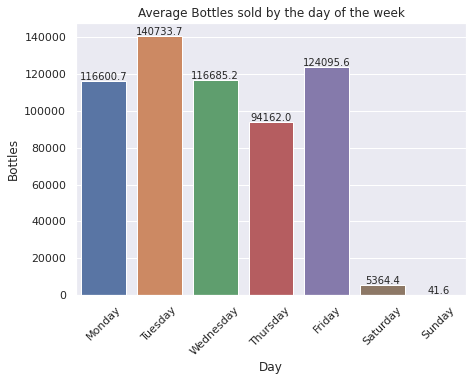

In [26]:
plt.figure(figsize=(7,5))
a_bottl_d = sns.barplot(bottles_sold_d_w.day_of_week, bottles_sold_d_w.Average, order=day_of_week)
plt.title("Average Bottles sold by the day of the week")
for i in a_bottl_d.patches:
  a_bottl_d.annotate(format(i.get_height(), '.1f'), 
  (i.get_x() + i.get_width() / 2., i.get_height()), 
  ha = 'center', va = 'center', 
  xytext = (0, 4), 
  textcoords = 'offset points',
  fontsize=10, rotation=0) 
plt.xlabel("Day")
plt.ylabel("Bottles")
plt.xticks(rotation=45)

In [27]:
# bottles sold by the liquor category by the day of the week
bottles_sold_cat_d_w = ps.sqldf("SELECT day_of_week, category_name, SUM(bottles_sold) AS sales FROM y2020 GROUP BY day_of_week, category_name ORDER BY day_of_week DESC")

Text(0.5, 138.5, 'Day')

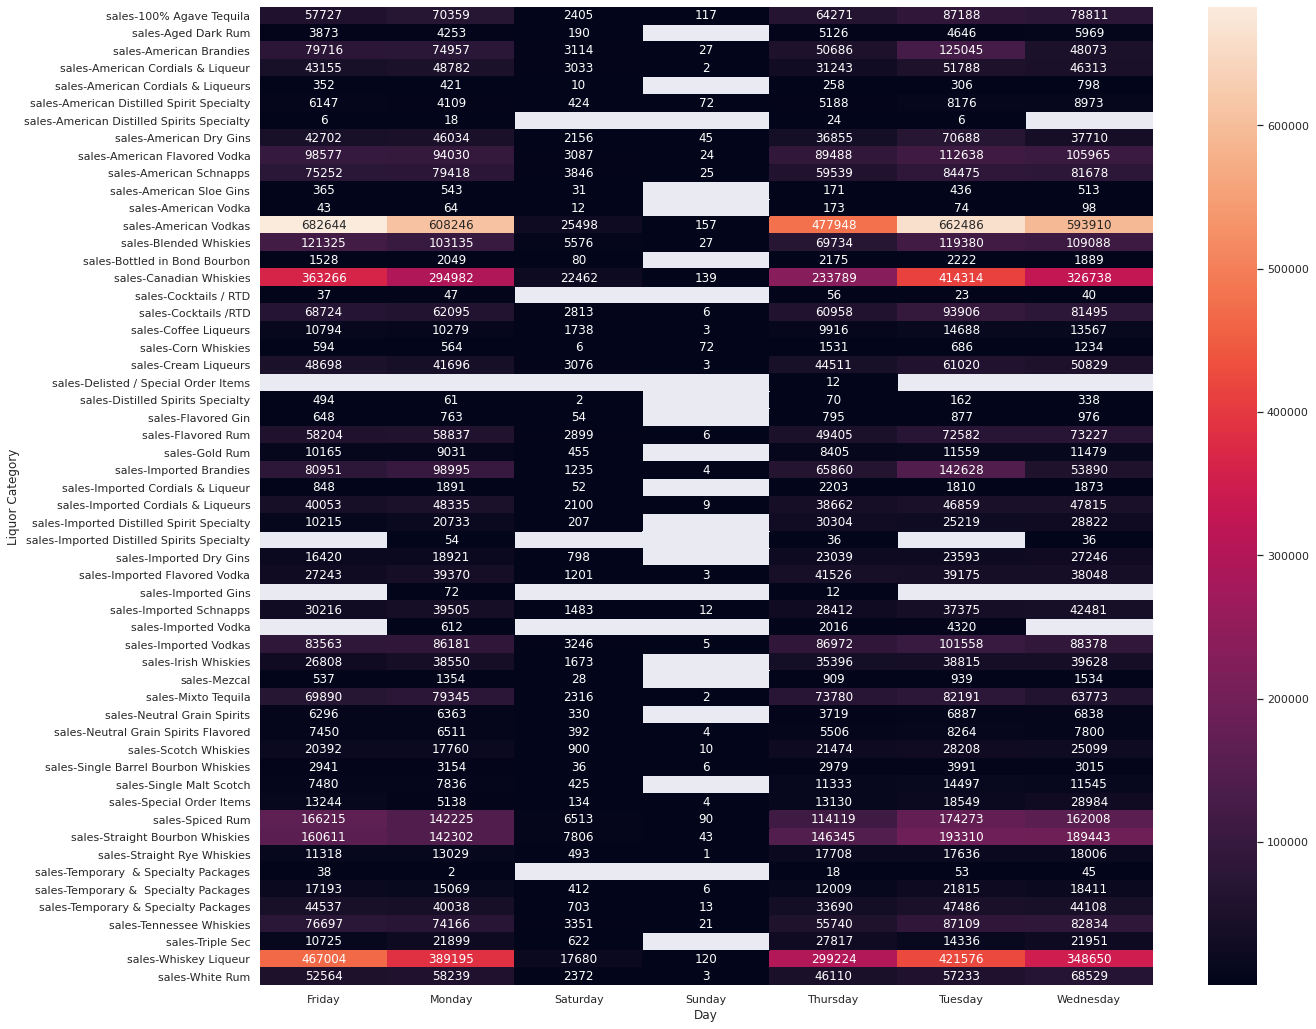

In [28]:
plt.figure(figsize=(20,18))
bottles_sold_cat_d_w_cf = bottles_sold_cat_d_w.pivot(index ='day_of_week', columns ='category_name', values =['sales']).T
sns.heatmap(bottles_sold_cat_d_w_cf, annot=True, fmt='g')
plt.ylabel('Liquor Category')
plt.xlabel('Day')

In [29]:
# bottles sold by the us holiday  
bottles_sold_h = ps.sqldf("SELECT SUM(bottles_sold) AS bottles, HOLIDAY_NAME FROM y2020 GROUP BY HOLIDAY_NAME ORDER BY bottles DESC")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

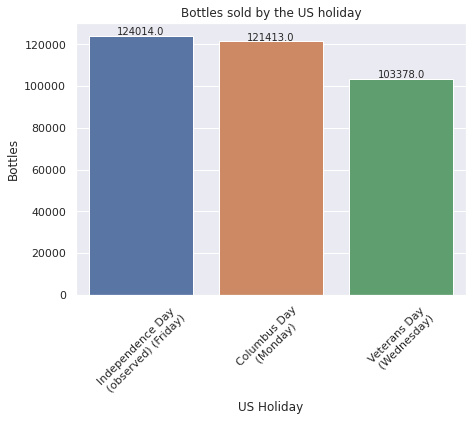

In [30]:
plt.figure(figsize=(7,5))
bottl_h = sns.barplot(bottles_sold_h.HOLIDAY_NAME, bottles_sold_h.bottles)
plt.title("Bottles sold by the US holiday")
for i in bottl_h.patches:
  bottl_h.annotate(format(i.get_height(), '.1f'), 
  (i.get_x() + i.get_width() / 2., i.get_height()), 
  ha = 'center', va = 'center', 
  xytext = (0, 4), 
  textcoords = 'offset points',
  fontsize=10, rotation=0) 
plt.xlabel("US Holiday")
bottl_h.set_xticklabels(['Independence Day\n (observed) (Friday)','Columbus Day\n (Monday)','Veterans Day\n (Wednesday)'])
plt.ylabel("Bottles")
plt.xticks(rotation=45)

In [31]:
# bottles sold by the liquor category on independence day (observed) (top 10)
bottles_sold_cat_in_d = ps.sqldf("SELECT SUM(bottles_sold) AS sales, category_name, HOLIDAY_NAME FROM y2020 WHERE HOLIDAY_NAME = 'Independence Day (observed)' GROUP BY category_name, HOLIDAY_NAME ORDER BY sales DESC LIMIT 10")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Category Name')

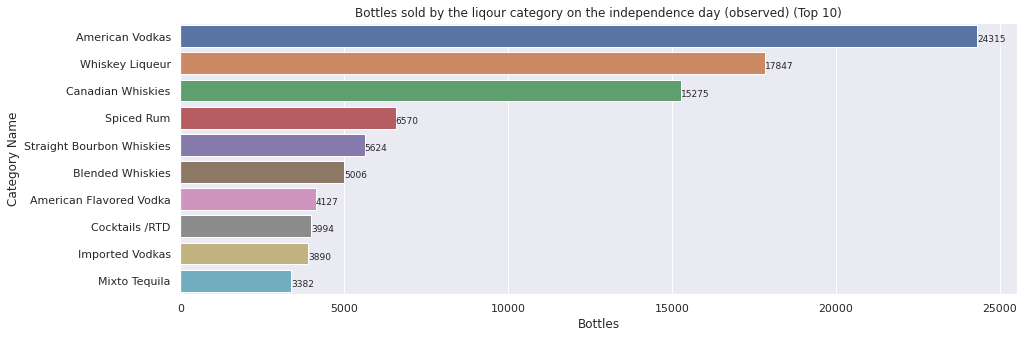

In [32]:
plt.figure(figsize=(15,5))
bottl_in_d = sns.barplot(bottles_sold_cat_in_d.sales, bottles_sold_cat_in_d.category_name)
for i in bottl_in_d.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_in_d.text(x, y, value, ha="left", fontsize=9)
plt.title("Bottles sold by the liqour category on the independence day (observed) (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("Category Name")

In [33]:
# average bottles sold by the liquor category on regular friday (top 10)
bottles_sold_cat_fri = ps.sqldf("SELECT SUM(bottles_sold) AS sales, category_name, day_of_week FROM y2020 WHERE day_of_week = 'Friday' GROUP BY category_name, day_of_week ORDER BY sales DESC LIMIT 10")
fri_cat_ave = [bottles_sold_cat_fri['sales'][i] / fri for i, x in enumerate(bottles_sold_cat_fri['sales'])]
bottles_sold_cat_fri.insert(3, "Average", fri_cat_ave, True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Category Name')

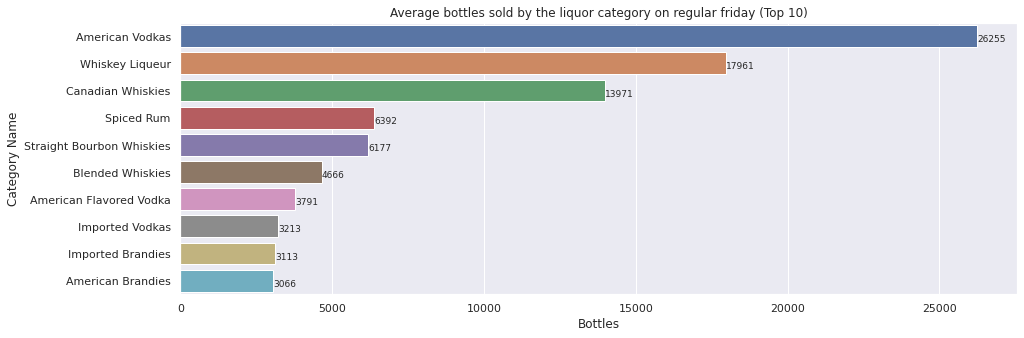

In [34]:
plt.figure(figsize=(15,5))
bottl_fri = sns.barplot(bottles_sold_cat_fri.Average, bottles_sold_cat_fri.category_name)
for i in bottl_fri.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_fri.text(x, y, value, ha="left", fontsize=9)
plt.title("Average bottles sold by the liquor category on regular friday (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("Category Name")

In [35]:
# bottles sold by the liquor category on columbus day (top 10)
bottles_sold_cat_col_d = ps.sqldf("SELECT SUM(bottles_sold) AS sales, category_name, HOLIDAY_NAME FROM y2020 WHERE HOLIDAY_NAME = 'Columbus Day' GROUP BY category_name, HOLIDAY_NAME ORDER BY sales DESC LIMIT 10")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Category Name')

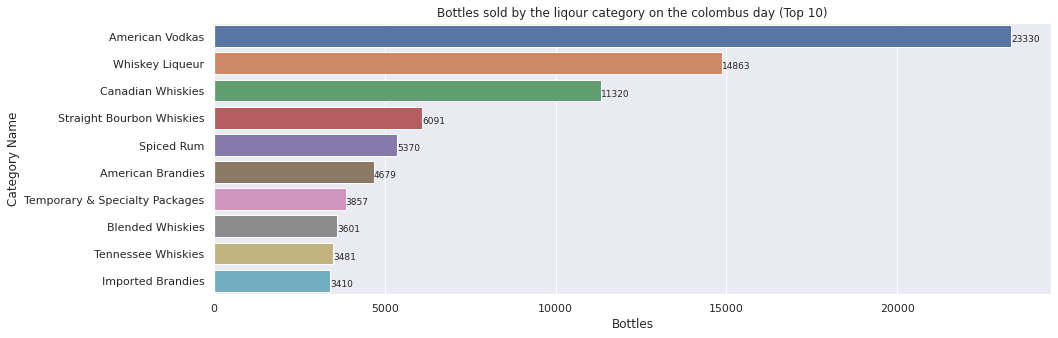

In [36]:
plt.figure(figsize=(15,5))
bottl_col_d = sns.barplot(bottles_sold_cat_col_d.sales, bottles_sold_cat_col_d.category_name)
for i in bottl_col_d.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_col_d.text(x, y, value, ha="left", fontsize=9)
plt.title("Bottles sold by the liqour category on the colombus day (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("Category Name")

In [37]:
# average bottles sold by the liquor category on regular monday (top 10)
bottles_sold_cat_mon = ps.sqldf("SELECT SUM(bottles_sold) AS sales, category_name, day_of_week FROM y2020 WHERE day_of_week = 'Monday' GROUP BY category_name, day_of_week ORDER BY sales DESC LIMIT 10")
mon_cat_ave = [bottles_sold_cat_mon['sales'][i] / mon for i, x in enumerate(bottles_sold_cat_mon['sales'])]
bottles_sold_cat_mon.insert(3, "Average", mon_cat_ave, True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Category Name')

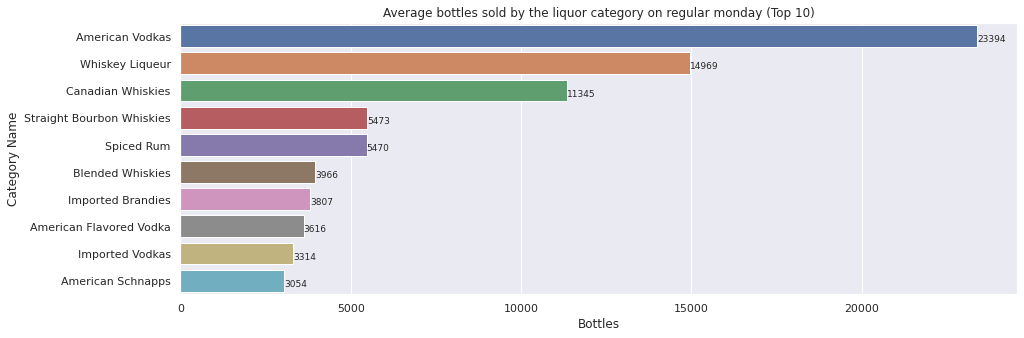

In [38]:
plt.figure(figsize=(15,5))
bottl_mon = sns.barplot(bottles_sold_cat_mon.Average, bottles_sold_cat_mon.category_name)
for i in bottl_mon.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_mon.text(x, y, value, ha="left", fontsize=9)
plt.title("Average bottles sold by the liquor category on regular monday (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("Category Name")

In [39]:
# bottles sold by the liquor category on veterans day (top 10)
bottles_sold_cat_vet_d = ps.sqldf("SELECT SUM(bottles_sold) AS sales, category_name, HOLIDAY_NAME FROM y2020 WHERE HOLIDAY_NAME = 'Veterans Day' GROUP BY category_name, HOLIDAY_NAME ORDER BY sales DESC LIMIT 10")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Category Name')

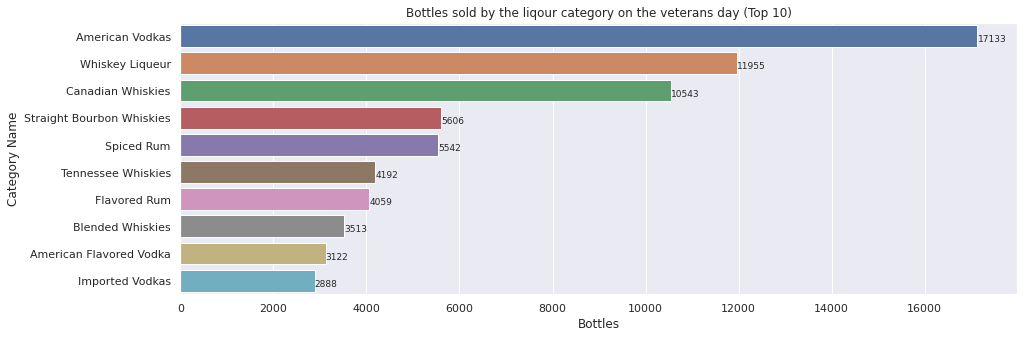

In [40]:
plt.figure(figsize=(15,5))
bottl_vet_d = sns.barplot(bottles_sold_cat_vet_d.sales, bottles_sold_cat_vet_d.category_name)
for i in bottl_vet_d.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_vet_d.text(x, y, value, ha="left", fontsize=9)
plt.title("Bottles sold by the liqour category on the veterans day (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("Category Name")

In [41]:
# average bottles sold by the liquor category on regular wednesday (top 10)
bottles_sold_cat_wed = ps.sqldf("SELECT SUM(bottles_sold) AS sales, category_name, day_of_week FROM y2020 WHERE day_of_week = 'Wednesday' GROUP BY category_name, day_of_week ORDER BY sales DESC LIMIT 10")
wed_cat_ave = [bottles_sold_cat_wed['sales'][i] / wed for i, x in enumerate(bottles_sold_cat_wed['sales'])]
bottles_sold_cat_wed.insert(3, "Average", wed_cat_ave, True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Category Name')

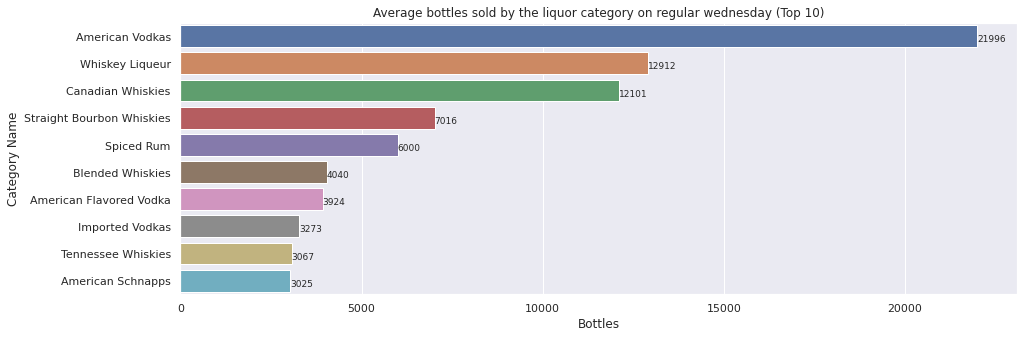

In [42]:
plt.figure(figsize=(15,5))
bottl_wed = sns.barplot(bottles_sold_cat_wed.Average, bottles_sold_cat_wed.category_name)
for i in bottl_wed.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_wed.text(x, y, value, ha="left", fontsize=9)
plt.title("Average bottles sold by the liquor category on regular wednesday (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("Category Name")

In [43]:
# bottles sold by the city of iowa
bottles_sold_city = ps.sqldf("SELECT SUM(bottles_sold) AS sales, city FROM y2020 GROUP BY city ORDER BY sales DESC")

In [44]:
top_10_bottles_sold_city = ps.sqldf("SELECT sales, city FROM bottles_sold_city LIMIT 10")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


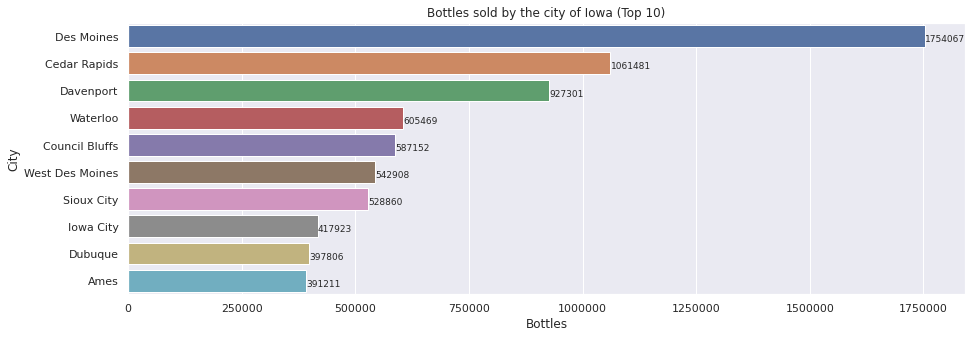

In [45]:
plt.figure(figsize=(15,5))
bottl_city = sns.barplot(top_10_bottles_sold_city.sales, top_10_bottles_sold_city.city)
for i in bottl_city.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_city.text(x, y, value, ha="left", fontsize=9)
plt.title("Bottles sold by the city of Iowa (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("City")
bottl_city.ticklabel_format(useOffset=False, style='plain', axis='x')

In [46]:
# bottles sold by the county
bottles_sold_county = ps.sqldf("SELECT SUM(bottles_sold) AS sales, county FROM y2020 GROUP BY county ORDER BY sales DESC")

In [47]:
top_10_bottles_sold_county = ps.sqldf("SELECT sales, county FROM bottles_sold_county LIMIT 10")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


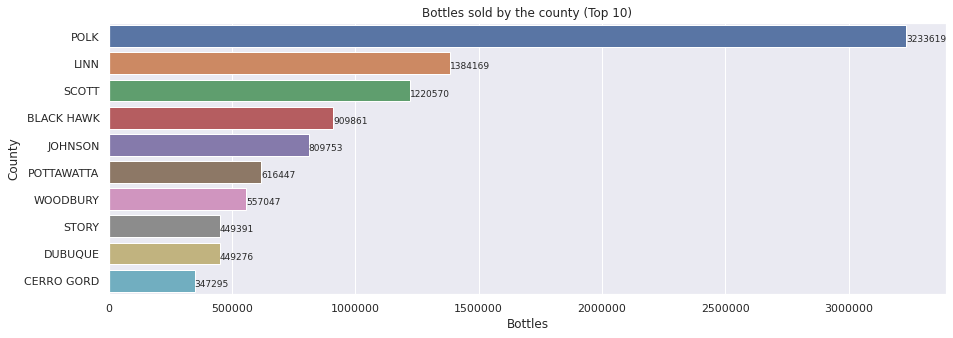

In [48]:
plt.figure(figsize=(15,5))
bottl_county = sns.barplot(top_10_bottles_sold_county.sales, top_10_bottles_sold_county.county)
for i in bottl_county.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_county.text(x, y, value, ha="left", fontsize=9)
plt.title("Bottles sold by the county (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("County")
bottl_county.ticklabel_format(useOffset=False, style='plain', axis='x')

In [49]:
# bottles sold by the store
top_10_bottles_sold_store = ps.sqldf("SELECT SUM(bottles_sold) AS sales, store_name FROM y2020 GROUP BY store_name ORDER BY sales DESC LIMIT 10")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Store Name')

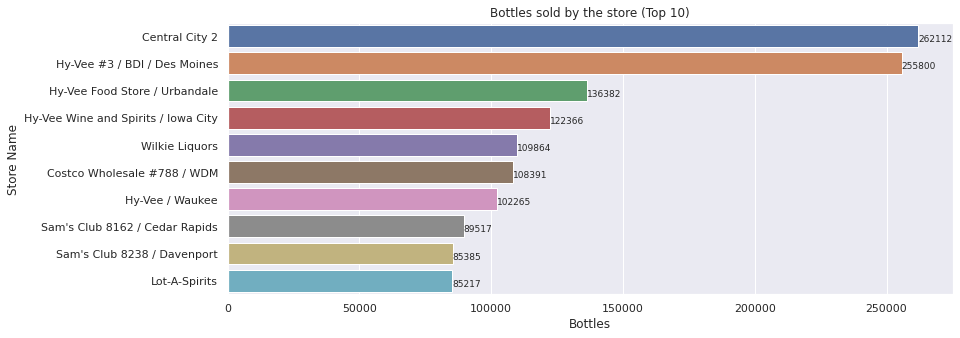

In [50]:
plt.figure(figsize=(13,5))
bottl_str = sns.barplot(top_10_bottles_sold_store.sales, top_10_bottles_sold_store.store_name)
for i in bottl_str.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_str.text(x, y, value, ha="left", fontsize=9)
plt.title("Bottles sold by the store (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("Store Name")

In [51]:
# bottles sold by the category in central city 2 store
bottles_sold_cat_sentcit2 = ps.sqldf("SELECT SUM(bottles_sold) AS sales, store_name, category_name FROM y2020 WHERE store_name = 'Central City 2' GROUP BY category_name, store_name ORDER BY sales DESC LIMIT 10")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Liquor Category')

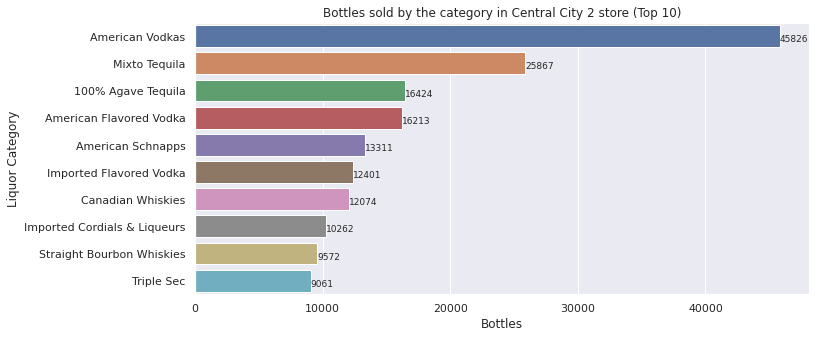

In [52]:
plt.figure(figsize=(11,5))
bottl_str_sentcit2 = sns.barplot(bottles_sold_cat_sentcit2.sales, bottles_sold_cat_sentcit2.category_name)
for i in bottl_str_sentcit2.patches:
  x = i.get_x() + i.get_width() + float(0.5)
  y = i.get_y() + i.get_height() - float(0.2)
  value = int(i.get_width())
  bottl_str_sentcit2.text(x, y, value, ha="left", fontsize=9)
plt.title("Bottles sold by the category in Central City 2 store (Top 10)")
plt.xlabel("Bottles")
plt.ylabel("Liquor Category")